# 03 — Greeks Dashboard (Live Streaming)

Stream live Greeks data and display a real-time updating dashboard.

This notebook demonstrates:
- Streaming first-order Greeks from the broker
- Computing second-order Greeks via the BSM engine
- Updating charts in-place using `ipywidgets`
- Time decay projections

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Setup

In [2]:
from options_analyzer.config import load_config
from options_analyzer.domain.streaming import GreeksUpdate, QuoteUpdate
from options_analyzer.factory import create_providers

config = load_config()

providers = await create_providers(config)
market_data = providers.market_data
account_provider = providers.account
print(f"Connected to {providers.provider_name}.")

Connected to TastyTrade (live).


## 2. Select Position

Fetch existing positions from the account, or manually construct one.

In [3]:
from datetime import UTC, date, datetime, timedelta
from decimal import Decimal

from options_analyzer.domain.enums import OptionType, PositionSide
from options_analyzer.domain.models import Leg, OptionContract, Position

UNDERLYING = "SPX"

# Try fetching existing positions
accounts = await account_provider.get_accounts()
account_id = accounts[0]
existing_legs = await account_provider.get_positions(account_id, UNDERLYING)

if existing_legs:
    position = Position(
        id="live-pos",
        name=f"{UNDERLYING} Live Position",
        underlying=UNDERLYING,
        legs=existing_legs,
        opened_at=datetime.now(tz=UTC),
    )
    print(f"Using live position with {len(existing_legs)} legs")
else:
    # Build a demo position: vertical put spread
    chain = await market_data.get_option_chain(UNDERLYING)
    spot_price = await market_data.get_underlying_price(UNDERLYING)

    target_date = date.today() + timedelta(days=35)
    sorted_exps = sorted(chain.keys())
    exp_date = min(sorted_exps, key=lambda d: abs((d - target_date).days))

    puts = sorted(
        [c for c in chain[exp_date] if c.option_type == OptionType.PUT],
        key=lambda c: c.strike,
    )
    atm_strike = min(puts, key=lambda c: abs(c.strike - spot_price)).strike
    put_by_strike = {c.strike: c for c in puts}

    short_strike = atm_strike - Decimal("5")
    long_strike = atm_strike - Decimal("10")

    position = Position(
        id="demo-vertical",
        name=f"{UNDERLYING} {long_strike}/{short_strike} Put Spread",
        underlying=UNDERLYING,
        legs=[
            Leg(contract=put_by_strike[long_strike], side=PositionSide.LONG, quantity=1, open_price=Decimal("2.00")),
            Leg(contract=put_by_strike[short_strike], side=PositionSide.SHORT, quantity=1, open_price=Decimal("3.50")),
        ],
        opened_at=datetime.now(tz=UTC),
    )
    print(f"No live positions found. Using demo: {position.name}")

print(f"\nPosition: {position.name}")
for leg in position.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    print(f"  {side:>5} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}")

Using live position with 12 legs

Position: SPX Live Position
  SHORT 2x PUT 6700.0
   LONG 1x PUT 6750.0
   LONG 1x PUT 6640.0
   LONG 1x CALL 7000.0
  SHORT 1x CALL 6990.0
   LONG 1x PUT 6725.0
  SHORT 2x PUT 6675.0
   LONG 1x PUT 6615.0
   LONG 1x PUT 6975.0
   LONG 1x PUT 6865.0
  SHORT 2x PUT 6925.0
   LONG 12x PUT 2000.0


## 3. Initialize Dashboard

Create the initial Greeks display with static data, using `ipywidgets.Output` for later in-place updates.

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML

from options_analyzer.engine.greeks_calculator import GreeksCalculator
from options_analyzer.engine.position_analyzer import PositionAnalyzer
from options_analyzer.visualization.greeks_charts import plot_greeks_summary

greeks_calc = GreeksCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)
analyzer = PositionAnalyzer(greeks_calc)

# Dashboard output areas
greeks_table_output = widgets.Output()
greeks_chart_output = widgets.Output()

def render_greeks_table(pos_greeks):
    """Render an HTML table of current Greeks."""
    agg = pos_greeks.aggregated
    rows = [
        ("Delta", f"{agg.first_order.delta:.4f}"),
        ("Gamma", f"{agg.first_order.gamma:.4f}"),
        ("Theta", f"{agg.first_order.theta:.4f}"),
        ("Vega", f"{agg.first_order.vega:.4f}"),
        ("Rho", f"{agg.first_order.rho:.4f}"),
        ("", ""),
        ("Vanna", f"{agg.second_order.vanna:.6f}"),
        ("Volga", f"{agg.second_order.volga:.6f}"),
        ("Charm", f"{agg.second_order.charm:.6f}"),
        ("Veta", f"{agg.second_order.veta:.6f}"),
        ("Speed", f"{agg.second_order.speed:.6f}"),
        ("Color", f"{agg.second_order.color:.6f}"),
    ]
    html = '<table style="font-family: monospace; background: #1a1a2e; color: #e0e0e0; padding: 10px;">'
    html += '<tr><th style="color: #ff6600; padding: 4px 12px;">Greek</th><th style="color: #ff6600; padding: 4px 12px;">Value</th></tr>'
    for name, val in rows:
        if name == "":
            html += '<tr><td colspan="2" style="border-top: 1px solid #2d2d44;"></td></tr>'
        else:
            html += f'<tr><td style="padding: 2px 12px;">{name}</td><td style="padding: 2px 12px; text-align: right;">{val}</td></tr>'
    html += '</table>'
    return html

# Initial render
initial_ivs = {leg.contract.symbol: 0.20 for leg in position.legs}
spot = float(await market_data.get_underlying_price(UNDERLYING))
pos_greeks = analyzer.position_greeks(position, spot, initial_ivs)

with greeks_table_output:
    display(HTML(render_greeks_table(pos_greeks)))

with greeks_chart_output:
    agg = pos_greeks.aggregated
    fig = plot_greeks_summary(
        {"delta": agg.first_order.delta, "gamma": agg.first_order.gamma,
         "theta": agg.first_order.theta, "vega": agg.first_order.vega},
        title=f"{position.name} — Greeks",
    )
    display(fig)

display(widgets.HBox([greeks_table_output, greeks_chart_output]))

## 4. Stream Live Greeks + Quotes

Connect to the DXLink streamer and update the dashboard with live data. Uses a combined stream:
- **Quote events** (high frequency): Update the underlying spot price on every bid/ask change, triggering BSM recomputation
- **Greeks events** (low frequency): Update implied volatility when the server recomputes IV

The stream runs for a configurable duration with time-based termination.

**Note**: Live streaming requires market hours. Outside market hours you may see stale data.

In [ ]:
import asyncio
import time

STREAM_DURATION_SECONDS = 30
REFRESH_INTERVAL = 1.0  # seconds between dashboard refreshes

# Collect contracts for streaming
contracts = [leg.contract for leg in position.legs]

if not contracts:
    print("No contracts available. Skipping live stream.")
else:
    live_ivs = dict(initial_ivs)  # Will be updated with live Greeks data
    tick_count = 0
    greeks_ticks = 0
    quote_ticks = 0

    print(f"Streaming Greeks + Quotes for {len(contracts)} contracts ({STREAM_DURATION_SECONDS}s)...")

    start_time = time.monotonic()
    last_refresh = 0.0

    try:
        async with asyncio.timeout(STREAM_DURATION_SECONDS + 10):
            async for update in market_data.stream_greeks_and_quotes(
                contracts=contracts,
                quote_symbols=[UNDERLYING],
            ):
                tick_count += 1

                match update:
                    case GreeksUpdate(event_symbol=sym, greeks=live_greeks):
                        greeks_ticks += 1
                        if sym in live_ivs and live_greeks.iv > 0:
                            live_ivs[sym] = live_greeks.iv

                    case QuoteUpdate(event_symbol=sym, bid_price=bid, ask_price=ask):
                        quote_ticks += 1
                        # Update spot from underlying quote
                        if sym == UNDERLYING and bid > 0 and ask > 0:
                            spot = float((bid + ask) / 2)

                now = time.monotonic()

                # Throttle dashboard refreshes to avoid excessive redraws
                if now - last_refresh >= REFRESH_INTERVAL:
                    pos_greeks = analyzer.position_greeks(position, spot, live_ivs)

                    greeks_table_output.clear_output(wait=True)
                    with greeks_table_output:
                        display(HTML(render_greeks_table(pos_greeks)))

                    greeks_chart_output.clear_output(wait=True)
                    with greeks_chart_output:
                        agg = pos_greeks.aggregated
                        fig = plot_greeks_summary(
                            {"delta": agg.first_order.delta, "gamma": agg.first_order.gamma,
                             "theta": agg.first_order.theta, "vega": agg.first_order.vega},
                            title=f"{position.name} — Greeks (Live)",
                        )
                        display(fig)

                    last_refresh = now

                # Time-based termination
                if now - start_time >= STREAM_DURATION_SECONDS:
                    break

    except TimeoutError:
        if tick_count == 0:
            print("Stream timed out with no data. Market may be closed — try again during market hours.")
        else:
            print(f"Stream safety timeout after {tick_count} ticks.")
    except asyncio.CancelledError:
        pass

    elapsed = time.monotonic() - start_time
    print(f"\nStream ended after {elapsed:.1f}s. Total ticks: {tick_count} (Greeks: {greeks_ticks}, Quotes: {quote_ticks})")

## 5. Time Decay View

Project how theta, charm, and veta evolve as the position approaches expiration.

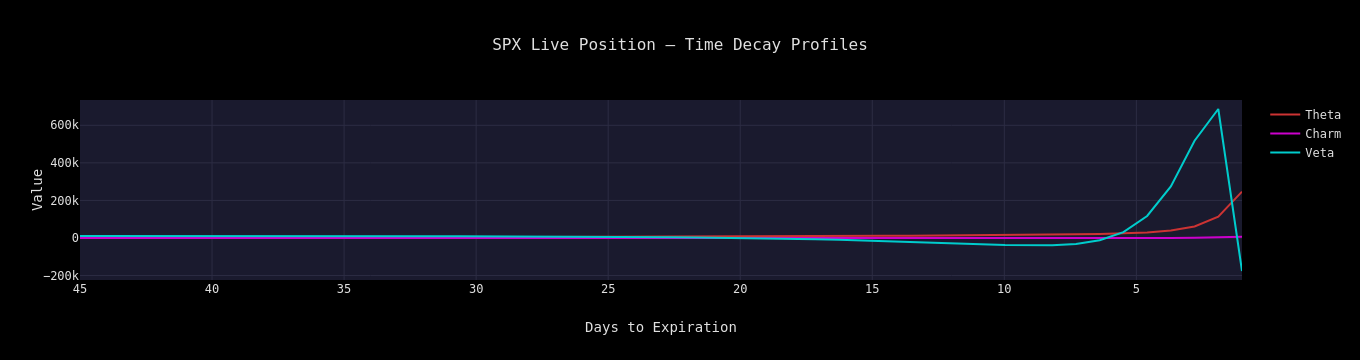

In [6]:
from options_analyzer.visualization.decay_charts import plot_decay_profiles

dte_range = np.linspace(1, 45, 50)
decay_greeks = analyzer.greeks_vs_time(position, spot, live_ivs if 'live_ivs' in dir() else initial_ivs, dte_range)

fig = plot_decay_profiles(
    dte_range,
    {"theta": decay_greeks["theta"], "charm": decay_greeks["charm"], "veta": decay_greeks["veta"]},
    title=f"{position.name} — Time Decay Profiles",
)
fig.show()

## 6. Greeks Summary Table

Full breakdown of all Greeks — per-leg and aggregated.

In [7]:
final_ivs = live_ivs if 'live_ivs' in dir() else initial_ivs
pos_greeks = analyzer.position_greeks(position, spot, final_ivs)

print(f"{'='*70}")
print(f"  {position.name} — Full Greeks Summary")
print(f"{'='*70}")

# Per-leg
for leg in position.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    label = f"{side} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}"
    lg = pos_greeks.per_leg.get(leg.contract.symbol)
    if lg:
        print(f"\n  {label}")
        print(f"    1st: D={lg.first_order.delta:>8.4f}  G={lg.first_order.gamma:>8.4f}  "
              f"T={lg.first_order.theta:>8.4f}  V={lg.first_order.vega:>8.4f}")
        print(f"    2nd: Va={lg.second_order.vanna:>8.5f}  Vo={lg.second_order.volga:>8.5f}  "
              f"Ch={lg.second_order.charm:>8.5f}")

# Aggregated
agg = pos_greeks.aggregated
print(f"\n  {'─'*60}")
print(f"  AGGREGATED")
print(f"    1st: D={agg.first_order.delta:>8.4f}  G={agg.first_order.gamma:>8.4f}  "
      f"T={agg.first_order.theta:>8.4f}  V={agg.first_order.vega:>8.4f}")
print(f"    2nd: Va={agg.second_order.vanna:>8.5f}  Vo={agg.second_order.volga:>8.5f}  "
      f"Ch={agg.second_order.charm:>8.5f}")
print(f"{'='*70}")

  SPX Live Position — Full Greeks Summary

  SHORT 2x PUT 6700.0
    1st: D= 58.0723  G= -0.1076  T=70606.7335  V=-240509.4294
    2nd: Va=174.03917  Vo=-337505.73322  Ch=35.75076

  LONG 1x PUT 6750.0
    1st: D=-31.4770  G=  0.0574  T=-34976.2398  V=124686.4994
    2nd: Va=-79.32186  Vo=134342.86706  Ch=-13.44095

  LONG 1x PUT 6640.0
    1st: D=-26.3654  G=  0.0496  T=-35415.9405  V=114704.3793
    2nd: Va=-93.60331  Vo=207743.19604  Ch=-22.37843

  LONG 1x CALL 7000.0
    1st: D= 51.1281  G=  0.0950  T=-58866.0194  V=117054.4936
    2nd: Va= 8.94265  Vo=-742.38001  Ch=26.71695

  SHORT 1x CALL 6990.0
    1st: D=-52.0752  G= -0.0941  T=59430.1610  V=-116942.8480
    2nd: Va=-2.43798  Vo=372.42214  Ch=-23.89589

  LONG 1x PUT 6725.0
    1st: D=-28.2801  G=  0.0654  T=-41912.1107  V=99284.6411
    2nd: Va=-95.99573  Vo=161891.69536  Ch=-31.58223

  SHORT 2x PUT 6675.0
    1st: D= 51.2403  G= -0.1203  T=83625.4873  V=-188973.6925
    2nd: Va=204.24209  Vo=-392740.29118  Ch=75.21542

  

## 7. Cleanup

In [8]:
await providers.disconnect()
print("Session disconnected.")

Session disconnected.
